In [14]:
# notebook setup

%load_ext autoreload
%autoreload 2

from irt2 import ipynb
ipynb.setup_logging()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import irt2
from irt2.create import EID, Mention

from pathlib import Path
from pprint import pprint

import yaml

import numpy as np
import matplotlib.pyplot as plt


with (irt2.ENV.DIR.CONF / 'create' / 'cde-l.yaml').open(mode='r') as fd:
    config = yaml.safe_load(fd)

# pprint(config)

In [16]:
from ktz.string import args_hash
from ktz.functools import Cascade

# set up cascade for development

def setup_cascade(config, keys):
    hash = args_hash(config)
    print(hash)

    prefix = 'create.ipynb'

    cascade = {name: f'{prefix}-{hash}-{name}' for name in keys}
    run = Cascade(path=irt2.ENV.DIR.CACHE, **cascade)

    return run


run = setup_cascade(config, keys=['matches', 'mentions', 'split'])

a0226ffed3d95554f15876d09d73706fe0a8933086fada8c6bb0c4f2


In [17]:
from irt2 import create


@run.cache('matches')
def load_matches():

    matches = create.index_matches(
        irt2.ENV.DIR.ROOT / config['source matches'],
        None,
    )

    print('\nmatch index:')
    print(f'  total: {len(matches.flat)}')
    print(f'  pages: {len(matches.keys("page"))}')
    print(f'   eids: {len(matches.keys("eid"))}')

    return matches


matches = load_matches()

In [18]:
# plot how matches distribute over entities

def plot_dist(
    y,
    title: str,
    subtitle: str,
    filenames: list[Path] = None,
):
    fig, ax = plt.subplots()
    fig.suptitle(title)

    ax.set_title(subtitle, color='#999')
    ax.set_yscale('log')

    ax.plot(np.arange(len(y)), y, color='#666')

    if filenames:
        for filename in filenames:
            fig.savefig(filename)


@run.when('matches')
def plot_distribution_idx(index, **kwargs):

    lens = {}
    for eid in index.keys('eid'):
        n = len(index.dis(eid=eid))
        lens[eid] = n

    lens = sorted(((n, eid) for eid, n in lens.items()), reverse=True)
    y = np.array([n for n, _ in lens])

    plot_dist(y=y, **kwargs)


plot_distribution_idx(
    index=matches,
    title="Matches Count",
    subtitle="{config['source graph']} ({config['source name']})",
)

In [19]:
from ktz.dataclasses import Index
from dataclasses import dataclass

print(f"\nmapping EIDS to mentions")
print(f"pruning at threshold: {config['prune mentions']}")


@dataclass
class Mentions:

    eid2mentions: dict[EID, dict[Mention, int]]
    norm2mentions: dict[str, str]


@run.cache('mentions')
def get_mentions(index: Index, prune: int):
    mentions = create.get_mentions(index=index, prune=prune)
    print(f'retained {len(mentions.eid2mentions)} mentions')
    return mentions


mentions = get_mentions(
    index=matches,
    prune=config['prune mentions'],
)


mapping EIDS to mentions
pruning at threshold: 5


In [20]:
# some example mentions

@run.when('mentions')
def print_mention_counts(mentions, eid):
    counts = mentions.eid2mentions[eid]

    for mention, count in sorted(counts.items(), key=lambda t: t[1], reverse=True):
        print(f"{count:5d} {mention}" )
    print()

print_mention_counts(mentions=mentions, eid='Q11708')
print_mention_counts(mentions=mentions, eid='Q49297')
print_mention_counts(mentions=mentions, eid='Q21077')

10036 southeast asia
  165 southeast
  125 south east asia
   32 southeast asian
   19 south east asian
   14 southeast asian countries
   13 southeastern asia
    9 southeast asian region
    8 sea
    5 south east
    5 southeastern

 9807 native american
 5211 native americans
 1640 indian
 1272 indians
 1106 american indian
  620 native
  424 american indians
  114 native americans in the united states
  106 american
   49 natives
   48 indigenous
   36 native american tribes
   34 indigenous peoples
   30 indian tribes
   24 united states
   22 tribe
   20 indigenous people
   18 native peoples
   16 tribal
   14 native american tribe
   12 american indian or alaska native
   10 native american peoples
   10 native american people
    9 native american indians
    9 aboriginal american
    9 indian affairs
    8 american indian and alaska native
    7 native indians
    7 native tribes
    7 native indian
    7 tribes
    6 first nations
    6 native american indian
    6 bands
  

In [21]:
# entities with most mentions

@run.when('mentions', 'matches')
def match_examples(matches, mentions):
    for eid, mdic in sorted(mentions.eid2mentions.items(), key=lambda t: len(t[1]), reverse=True)[:20]:
        print(len(mdic), eid, list(matches.get(eid=eid))[0].entity)


match_examples(matches, mentions)

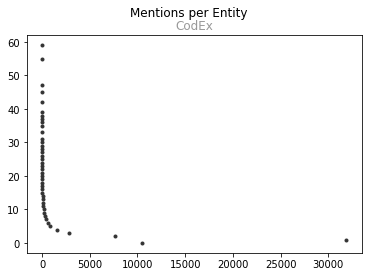

In [22]:
from collections import Counter


@run.when('mentions')
def plot_mention_counts(mentions, title, subtitle, **kwargs):
    counts = Counter()
    for countdic in mentions.eid2mentions.values():
        counts[len(countdic)] += 1

    y, x = zip(*sorted(counts.items()))

    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.set_title(subtitle, color='#999')

    ax.scatter(x, y, **kwargs)


plot_mention_counts(
    mentions=mentions,
    title="Mentions per Entity",
    subtitle=config['source name'],
    color='#333',
    marker='.',
)

In [23]:
from irt2.graph import Graph
from irt2.graph import load_graph


graph = load_graph(
    config['graph loader'],
    config['graph name'],
    *[irt2.ENV.DIR.ROOT / path for path in config['graph loader args']],
    **{k: irt2.ENV.DIR.ROOT / path for k, path in config['graph loader kwargs'].items()},
)


print(graph.description)

IRT2 GRAPH: CodEx-M
  nodes: 17050
  edges: 206205 (51 types)
  degree:
    mean 24.19
    median 13



In [24]:
# split triples/vertices/mentions:
#  - select all mentions of concept entities
#  - shuffle and split remaining mentions randomly (cw/ow-validation/ow-test)
#  - assign vertices based on mention split to be either cw or ow
#  - assign triples based on vertex split

from irt2.create import Split

def create_split(config, graph, mentions):

    ratio_train = config['target mention split']
    print(f"targeting {int(ratio_train * 100)}% closed-world mentions")

    ratio_val = config['target validation split']
    print(f"using {int(ratio_val * 100)}% open-world mentions for validation")

    split = Split.create(
        graph,
        mentions=mentions,
        seed=config['seed'],
        ratio_train=ratio_train,
        ratio_val=ratio_val,
        concept_rels=config['concept relations'],
        include_rels=config['include relations'],
        exclude_rels=config['exclude relations'],
    )

    print('running self-check...')
    split.check()
    print('self-check passed')

    print(split.description)
    print(f'\nretained {len(split.relations)}/{len(graph.source.rels)} relations')

    return split

split = create_split(config, graph, mentions)

targeting 70% closed-world mentions
using 30% open-world mentions for validation


irt2.create - retaining 16173/17050 vertices


irt2.create - set aside 12779 concept mentions


irt2.create - splitting mention candidates: 0:9799:12825:19887


running self-check...


self-check passed


                               mentions    vertices    triples
---------------------------  ----------  ----------  ---------
concept                           12779        2200      11122
closed world                      22578        9769     158463
open world (exclusive)            10088        5251       1243
open world (inklusive)            10088        7696      95712
open/validation (inklusive)
heads                              2994        2706      33900
tails                              1126         958       3667
both                               3026        2732      36804
open/test (inklusive)
heads                              6993        5690      69245
tails                              2503        1877       7010
both                               7062        5737      73203

retained 46/51 relations


In [45]:
from tabulate import tabulate
from irt2.create import create_dataset

dataset, counts = create_dataset(
    out=irt2.ENV.DIR.DATA / 'irt2' / 'cde' / 'large',
    config=config,
    split=split,
    overwrite=True
)

print(f"\n{dataset}\n")
print(tabulate(sorted(counts.items())))

irt2.create - vid mapping: retained 15020


irt2.create - rid mapping: retained 46


irt2.create - mid mapping: retained 32666


irt2.create - open/validation: added 38363 head tasks from 33900 triples


irt2.create - open/validation: added 4454 tail tasks from 3667 triples


irt2.create - open/test: added 88620 head tasks from 69245 triples


irt2.create - open/test: added 9944 tail tasks from 7010 triples


irt2.create - distributing text, this might take a while...


irt2.create - distributed 30923100 sentences



IRT2/CDE-L: 15020 vertices | 46 relations | 32666 mentions

------------------------  --------
ids mentions                 32666
ids relations                   46
ids vertices                 15020
open closed mentions         22578
open open mentions           10088
open test head               88620
open test tail                9944
open validation head         38363
open validation tail          4454
text retained test         1180605
text retained training    18616203
text retained validation    477826
text skipped eid          10542870
text skipped mid            105596
text total                30923100
triples closed-world        158463
------------------------  --------


In [42]:
def trace():
    vid = 14719

    print(dataset.vertices[vid])
    print(vid in dataset.open_mentions_test)

    print(dataset.open_mentions_test[vid])
    print(dataset.mentions[30429])

    lookup = {
        (vid, dataset.mentions[mid]): mid
        for vid, mid in unbucket(dataset.open_mentions_test)
    }

    print(lookup[vid, 'stefan stambolov'])

    # missing mention: "stambolov"

    print(mentions.eid2mentions['Q313833'])